In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr 
import equinox as eqx
import optax
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import trange

from vit import (
    ImageEmbedding,
    TokenPositionalEmbedding,
    MultiHeadAttentionLayer,
    VisionTransformer
)

cmap = "gray_r"

In [2]:
key = jr.key(0)

n_pix = 64
c = 1
p = 4
n_heads = 4
embed_dim = 8
dropout = 0.1
hidden_dim = 32

model = VisionTransformer(
    c=c, # Channels
    p=p, # Patch size
    embed_dim=embed_dim, 
    n_layers=2,
    n_heads=n_heads,
    hidden_dim=hidden_dim,
    dropout_rate=0.1,
    output_dim=1, # Predict radius
    key=key
)

x = jnp.ones((1, 32, 32))
a, b = model(x, key=key)
a.shape, [_.shape for _ in b]

((1,), [(4, 65, 65), (4, 65, 65)])

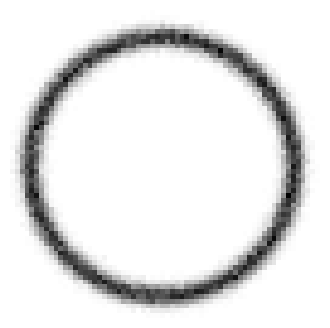

In [3]:

x, y = datasets.make_circles(100000, noise=0.05)
x = x[y == 0.]
y = y[y == 0.]

plt.figure(figsize=(4., 4.))
x, *_ = plt.hist2d(*x.T, bins=n_pix, cmap=cmap)
plt.axis("off")
plt.show()

x = x[jnp.newaxis, ...]

In [4]:
i = ImageEmbedding(c, p, embed_dim, key=key)
embedding = i(x)

print(embedding.shape)

plt.figure()
plt.imshow(embedding.T, cmap=cmap)
plt.axis("off")
plt.show()

(257, 8)


In [5]:
t = TokenPositionalEmbedding(
    c, p, embed_dim=embed_dim, dropout_rate=dropout, key=key
)
token_embedding = t(x, key=key)

print(token_embedding.shape)

plt.figure()
plt.imshow(token_embedding.T, cmap=cmap)
plt.axis("off")
plt.show()

(257, 8)


(64, 8)


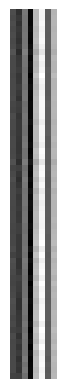

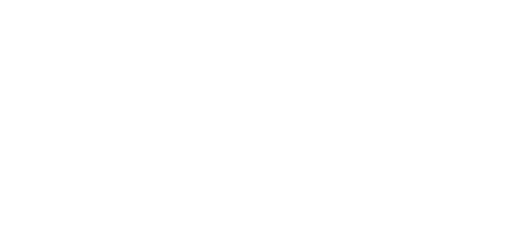

In [6]:
a = MultiHeadAttentionLayer(embed_dim, n_heads, dropout, key=key)

q = jnp.ones((64, embed_dim))
k = jnp.ones((32, embed_dim))
v = jnp.ones((32, embed_dim))
o, atts = a(q, k, v, key=key)

print(o.shape)

plt.figure()
plt.imshow(o.T, cmap=cmap)
plt.axis("off")
plt.show()

fig, axs = plt.subplots(1, n_heads)
for att, ax in zip(atts, axs):
    ax.imshow(att.T, cmap=cmap)
    ax.axis("off")
plt.show()

In [7]:
# Make dataset
n_data = 1_000
n_points_circle = 100_000

X = np.zeros((n_data, 1, n_pix, n_pix))
Y = np.zeros((n_data, 1))
for i in range(n_data):
    key = jr.fold_in(key, i)

    r = jr.uniform(key) * 0.8 + 0.1
    x, y = datasets.make_circles(n_points_circle, noise=0.05, factor=r.item())

    # Grab second circle
    x = x[y == 1.]
    x, *_ = np.histogramdd(x, bins=n_pix, range=[[-1., 1.], [-1., 1.]]) # range=jnp.array([-1.0, 1.0])

    X[i, 0] = x
    Y[i] = r
    print(f"\r{i=}", end="")

i=999

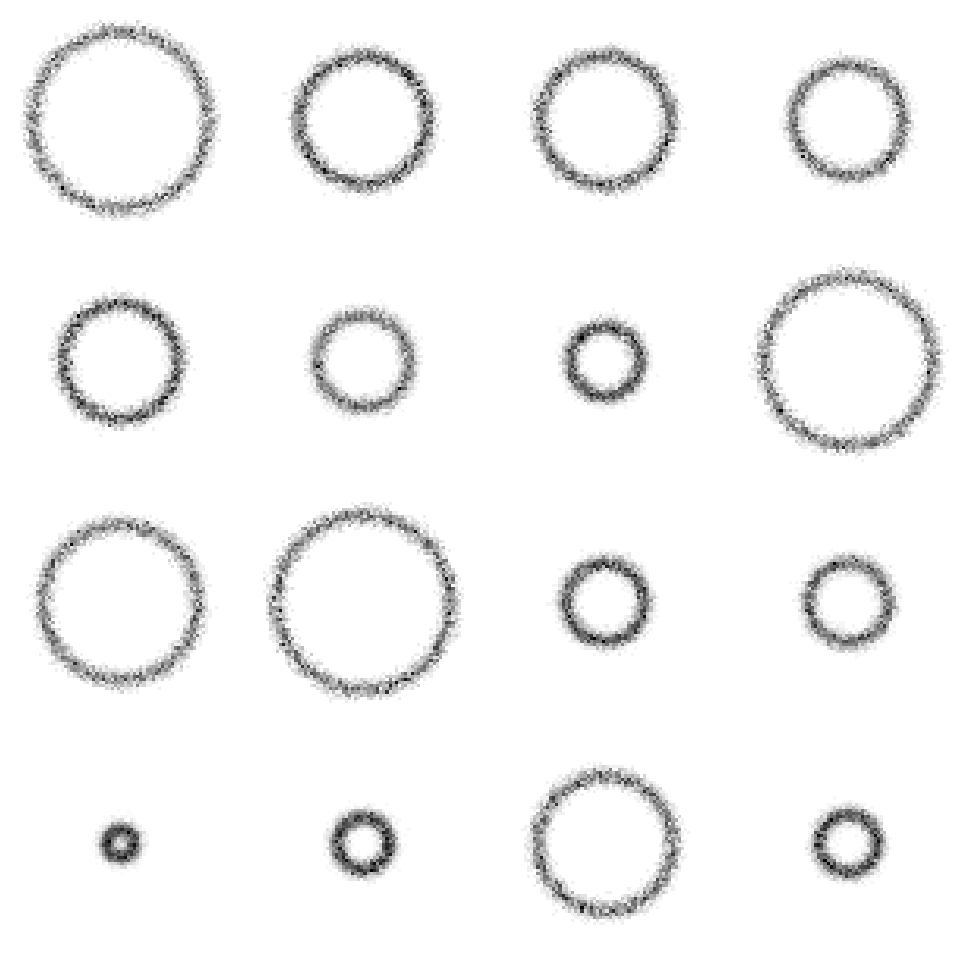

In [8]:
fig, axs = plt.subplots(4, 4, dpi=200, figsize=(6., 6.)) 
for i, ax in enumerate(axs.ravel()):
    ax.imshow(X[i].squeeze(), cmap=cmap)
    ax.axis("off")
plt.show()

In [9]:
n_epochs = 2000
n_batch = 2000
opt = optax.adam(learning_rate=1e-4)

opt_state = opt.init(eqx.filter(model, eqx.is_array))

n_train = int(0.8 * n_data)
train_ds = TensorDataset(
    torch.as_tensor(X[:n_train]), torch.as_tensor(Y[:n_train])
)
valid_ds = TensorDataset(
    torch.as_tensor(X[n_train:]), torch.as_tensor(Y[n_train:])
)


def loss(model, keys, x, y):
    y_, _ = jax.vmap(model)(x, key=keys)
    return jnp.square(jnp.subtract(y, y_)).mean()


@eqx.filter_jit
def make_step(key, model, opt_state, x, y):
    keys = jr.split(key, len(x))
    loss_value, grads = eqx.filter_value_and_grad(loss)(model, keys, x, y)
    updates, opt_state = opt.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value


@eqx.filter_jit
def eval(model, key, x, y):
    model = eqx.nn.inference_mode(model, True)
    keys = jr.split(key, len(x))
    loss_value = loss(model, keys, x, y)
    return loss_value


def prepare(x, y):
    return x.numpy(), y.numpy()


key_train, key_valid = jr.split(key)

losses = []
with trange(n_epochs) as bar:
    set_dl_train = DataLoader(train_ds, batch_size=n_batch)
    set_dl_valid = DataLoader(valid_ds, batch_size=n_batch)

    for _ in bar:
        Lt = 0.
        for t, (x, y) in enumerate(set_dl_train):
            key = jr.fold_in(key_train, t)
            x, y = prepare(x, y)
            model, opt_state, _Lt = make_step(key, model, opt_state, x, y)
            Lt += _Lt

        Lv = 0.
        for v, (x, y) in enumerate(set_dl_valid):
            x, y = prepare(x, y)
            _Lv = eval(model, key_valid, x, y)
            Lv += _Lv
        
        Lt = Lt.item() / (t + 1) 
        Lv = Lv.item() / (v + 1)
        losses.append((Lt, Lv))
        bar.set_postfix_str(f"{Lt=:.3E} {Lv=:.3E}")

  0%|          | 0/2000 [00:00<?, ?it/s]

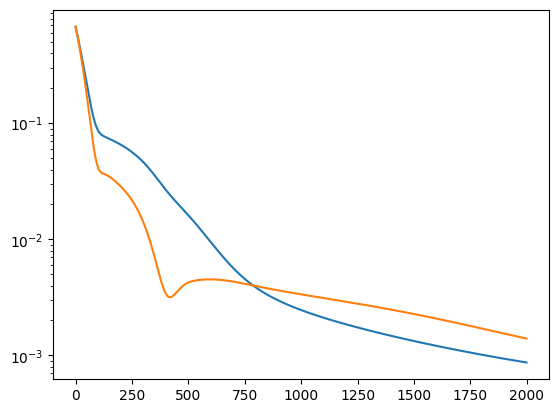

In [ ]:
plt.figure()
plt.semilogy(losses)
plt.show()

In [ ]:
# Make test dataset
n_data_test = 10_000

X_ = np.zeros((n_data_test, 1, n_pix, n_pix))
Y_ = np.zeros((n_data_test, 1))
for i in range(n_data_test):
    key = jr.fold_in(key, i)

    r = jr.uniform(key) * 0.8 + 0.1
    x, y = datasets.make_circles(n_points_circle, noise=0.05, factor=r.item())

    # Grab second circle 
    x = x[y == 1.]
    x, *_ = np.histogramdd(x, bins=n_pix) # range=jnp.array([-1.0, 1.0])

    X_[i, 0] = x
    Y_[i] = r
    print(f"\r{i=}", end="")

i=9999

(10000, 1) (10000, 1)


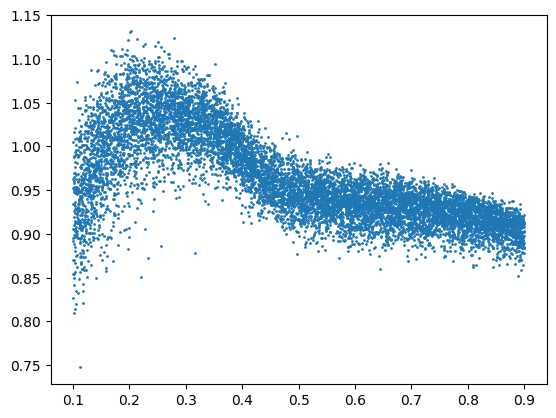

In [ ]:
model = eqx.nn.inference_mode(model, True)
Y__, _ = jax.vmap(model)(X_)

print(Y_.shape, Y__.shape)

plt.figure()
plt.scatter(Y_, Y__, s=1.)
plt.show()